# Jacksonville Apartment Population Statistics

In this notebook I will be parsing through some of the rental properties in Jacksonville to get information on them.

In [33]:
import requests
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
import platform
from bs4 import BeautifulSoup
import pandas as pd
from helper import parse_page, geocode_address
from helper import notAComplex
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Functions

In [91]:
import numpy as np

def parse_page(soup, df):
    for item in soup.find_all('article', class_ = 'placard'):
        url = ''
        rent = ''
        contact = ''

        if item.find('a', class_ = 'property-link') is None:
            url = np.nan
        else:
            url = item.find('a', class_ = 'property-link').get('href')


        if item.find('span', class_='js-placardTitle title') is None: 
            name = np.nan
        else:
            name = item.find('span', class_ = 'js-placardTitle title').getText().strip()

        if item.find('div', class_ = 'property-address js-url') is None:
            address = np.nan
        else:
            address = item.find('div', class_ = 'property-address js-url').getText().strip()
        
        if item.find('p', class_='property-pricing') is None: 
            rent = np.nan
        else:
            rent = item.find('p', class_='property-pricing').getText().strip()

        if item.find('p', class_='property-beds') is None: 
            beds = np.nan
        else:
            beds = item.find('p', class_='property-beds').getText().strip()

        df.loc[len(df)] = [url, name, address, rent, beds]
        print(len(df), [url, name, address, rent, beds])

# Function to convert an address into latitude and longitude coordinates
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

def geocode_address(address):
    # Initialize the geocoder with a user-agent name
    geolocator = Nominatim(user_agent='apartmentParser')
    try:
        # Attempt to get the geolocation data for the given address
        location = geolocator.geocode(address, timeout=10)
        
        # If a location is found, return latitude and longitude as a tuple
        if location is not None:
            return location.latitude, location.longitude
        else:
            return 'NOT FOUND'  # If the address cannot be found

    except GeocoderTimedOut:
        return 'TIMEOUT'  # Handle timeout errors to prevent crashes

    except Exception as e:
        return f'ERROR: {e}'  # Catch any other unexpected errors
    
def notAComplex(row):
    if row['Address'] is None and row['Complex Name'] and row['Complex Name'][-5:].isdigit():
        row['Address'] = row['Complex Name']
        row['Complex Name'] = None
    return row

# Scrape for main complexes

In [ ]:

# Create an empty DataFrame to store apartment listings
df = pd.DataFrame(columns=['URL', 'Name', 'Address', 'Rent', 'Beds'])

# Define the base URL for apartment listings in Jacksonville, FL (1-bedroom max filter)
URL = 'https://www.apartments.com/jacksonville-fl/'

# Initialize the web driver variable
web_driver = None

# Check if an existing web driver instance is provided
if web_driver is not None:
    driver = web_driver
else:
    # Set up Selenium WebDriver options (headless mode for efficiency)
    options = Options()
    options.headless = True

    # Use a different Firefox binary path if running on Debian
    if 'debian' in platform.platform():
        driver = webdriver.Firefox(firefox_binary='/usr/bin/firefox-esr', options=options)
    else:
        driver = webdriver.Firefox(options=options)

# Open the first page of apartment listings
driver.get(URL)

# Parse the current page's HTML content
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Locate the main container that holds apartment listings
soup = soup.find('div', class_='placardContainer')

# extract and store listing data from the page
parse_page(soup, df)

# Loop through rest of the pages to scrape additional listings
#Check how many pages there are available to scrape
pages = int(soup.find('span', class_ = "pageRange").getText().strip().split(' ')[-1])

for pageNo in range(2, pages+1):
    print('PAGE NUMBER', pageNo)
    # Construct the URL for the next page
    URL = f'https://www.apartments.com/jacksonville-fl/{pageNo}/'

    # Load the next page
    driver.get(URL)

    # Parse the page's HTML content
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Locate the main listing container
    soup = soup.find('div', class_='placardContainer')

    # Extract and store listing data from the page
    parse_page(soup, df)

#driver.close()

# Initial Cleaning

In [ ]:
df.head()

It appears that some of the listings were not apartment complexes, but individual rental properties. They are saved with no address, but the complex name is the address. lets fix that.

In [4]:
# There were some advertisements at the bottom. they came out to rows with all NaN. get rid of those too
df = df.dropna(how = 'all')
print(f'So far we have {df.shape[0]} entries.')
df.head()

So far we have 700 entries.


URL  \
0  https://www.apartments.com/golden-shores-of-ja...   
1  https://www.apartments.com/river-house-jackson...   
2  https://www.apartments.com/the-solera-at-kenda...   
3  https://www.apartments.com/the-oasis-at-town-c...   
4  https://www.apartments.com/lofts-at-brooklyn-j...   

                            Name  \
0  Golden Shores of Jacksonville   
1                    River House   
2     The Solera at Kendall West   
3       The Oasis at Town Center   
4              Lofts at Brooklyn   

                                        Address             Rent  \
0         7703 Hare Ave, Jacksonville, FL 32211    $580 - $1,149   
1    1655 Prudential Dr, Jacksonville, FL 32207  $1,449 - $2,994   
2       1462 Solera Ter, Jacksonville, FL 32211  $1,349 - $2,059   
3  10667 Brightman Blvd, Jacksonville, FL 32246  $1,534 - $2,698   
4        190 Chelsea St, Jacksonville, FL 32204  $1,305 - $1,425   

              Beds  
0  Studio - 2 Beds  
1  Studio - 3 Beds  
2         1-3 Beds  
3         1-3 Beds  
4  Studio - 3 Beds

In [5]:
# All of the mentioned listings have the zip code at the end. we can use that to separate.

def notAComplex(row):
    # Check if 'Address' is NaN (missing) and 'Name' ends with digits
    if pd.isna(row['Address']) and row['Name'] and row['Name'][-5:].isdigit():
        row['Address'] = row['Name']
        row['Name'] = row['Name'].split(',')[0]
    return row

df = df.apply(notAComplex, axis=1)

In [ ]:
df.head()

In [51]:
df.to_csv('Jacksonville Complexes_copy.csv', index = False)

# Go through complexes DF and get all units in those complexes

I have to use selenium here even though it is slow - apartments.com doesn't like scrapers. Also include 3s wait between requests to be polite

In [ ]:
df = pd.read_csv('Jacksonville Complexes_copy.csv')
urlList = list(df["URL"])
# Create an empty list to store data
data = []

# Initialize the web driver variable
web_driver = None

# Check if an existing web driver instance is provided
if web_driver is not None:
    driver = web_driver
else:
    # Set up Selenium WebDriver options (headless mode for efficiency)
    options = Options()
    options.headless = True

    # Use a different Firefox binary path if running on Debian
    if 'debian' in platform.platform():
        driver = webdriver.Firefox(firefox_binary='/usr/bin/firefox-esr', options=options)
    else:
        driver = webdriver.Firefox(options=options)

for url in urlList:
    print(url)
    driver.get(url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #Get a list of all the floorplans available
    # Find all floor plans
    floor_plans = soup.findAll('div', class_='pricingGridItem multiFamily hasUnitGrid v3 UnitLevel_var2')

    for floor_plan in floor_plans:
        floor_plan_name = floor_plan.find('span', class_='modelName').text.strip()
        units = floor_plan.findAll('div', class_='grid-container js-unitExtension')

        for unit in units:
            unit_name = unit.find('div', class_='unitColumn column').text.strip()
            pricing = unit.find('div', class_='pricingColumn column').text.replace('price', '').strip()
            area = unit.find('div', class_='sqftColumn column').text.replace('square feet', '').strip()
            availability = unit.find('div', class_='availableColumn column').text.replace('availibility', '').strip()

            # Extract Beds & Baths
            beds, baths = None, None
            details = floor_plan.find('span', class_='detailsTextWrapper')
            if details:
                for detail in details:
                    if 'Bed' in detail.text:
                        beds = detail.text.strip()
                    if 'Bath' in detail.text:
                        baths = detail.text.strip()

            # Append data to list
            data.append([url, floor_plan_name, pricing, unit_name, area, availability, beds, baths])


new_units = pd.DataFrame(data, columns=["Complex URL", "Floor Plan Name", "Price", "Unit Name", "Square Footage", "Availability", "Beds", "Baths"])
print(new_units)
driver.close()

In [ ]:
new_units.to_csv('brandNewUnits.csv', index = False)

# Finalize and clean up for analysis

In [212]:
newUnits = pd.read_csv('brandNewUnits.csv')
df = pd.read_csv('Jacksonville Complexes_copy.csv')

In [214]:
finalDF = newUnits.merge(df[['Name', 'URL', 'Address']], left_on = "Complex URL", right_on = "URL", how = 'left')

In [215]:
finalDF.head()

Complex URL Floor Plan Name   Price  \
0  https://www.apartments.com/waterside-townhomes...    Talbot + Den  $2,250   
1  https://www.apartments.com/waterside-townhomes...    Talbot + Den  $2,250   
2  https://www.apartments.com/waterside-townhomes...    Talbot + Den  $2,250   
3  https://www.apartments.com/waterside-townhomes...    Talbot + Den  $2,250   
4  https://www.apartments.com/waterside-townhomes...    Talbot + Den  $2,250   

  Unit Name Square Footage Availability    Beds      Baths  \
0  Unit 052          1,638          Now  2 Beds  2.5 Baths   
1  Unit 053          1,638          Now  2 Beds  2.5 Baths   
2  Unit 115          1,638          Now  2 Beds  2.5 Baths   
3  Unit 119          1,638          Now  2 Beds  2.5 Baths   
4  Unit 049          1,638          Now  2 Beds  2.5 Baths   

                                Name  \
0  Waterside Townhomes at River City   
1  Waterside Townhomes at River City   
2  Waterside Townhomes at River City   
3  Waterside Townhomes at River City   
4  Waterside Townhomes at River City   

                                                 URL  \
0  https://www.apartments.com/waterside-townhomes...   
1  https://www.apartments.com/waterside-townhomes...   
2  https://www.apartments.com/waterside-townhomes...   
3  https://www.apartments.com/waterside-townhomes...   
4  https://www.apartments.com/waterside-townhomes...   

                                          Address  
0  14277 River Station Ln, Jacksonville, FL 32218  
1  14277 River Station Ln, Jacksonville, FL 32218  
2  14277 River Station Ln, Jacksonville, FL 32218  
3  14277 River Station Ln, Jacksonville, FL 32218  
4  14277 River Station Ln, Jacksonville, FL 32218

In [4]:
finalDF.to_csv('Units.csv', index = False)
finalDF = pd.read_csv('Units.csv')

In [5]:
pd.isna(finalDF).sum()

Unnamed: 0            0
Floor Plan Name       0
Price                 0
Unit Name             0
Square Footage        0
Availability          0
Beds                  0
Baths                 0
Name                  0
URL                   0
Address               0
Longitude             0
Latitude              0
geometry              0
x_jittered            0
y_jittered            0
Neighborhood          0
DollarperSqFoot       0
NeighborhoodNumber    0
dtype: int64

I see two entries where square footage is missing. lets start there.

In [9]:
# Lets pull up the URLs that are having an issue with square footage.
finalDF[finalDF['Square Footage'].isna()]['URL']

Series([], Name: URL, dtype: object)

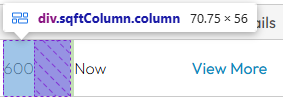
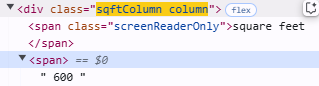

This appears to be an issue where the sqftcolumn column is a flex box on this page. I can write a whole new script to fix just two of these entries, or I can just write in that its 600 sq feet.

In [6]:
finalDF.loc[finalDF['Square Footage'].isna(), 'Square Footage'] = 600
pd.isna(finalDF).sum()

Complex URL          0
Floor Plan Name      0
Price                0
Unit Name            0
Square Footage       0
Availability         0
Beds               356
Baths                0
Name                 0
URL                  0
Address            352
dtype: int64

That was easy. now lets address the address column

In [7]:
# Lets see how many complexes are giving us problems here
finalDF.loc[finalDF['Address'].isna(), 'URL'].unique()

array(['https://www.apartments.com/arium-surfside-at-ponte-vedra-beach-ponte-vedra-beach-fl/cjv6ypd/',
       'https://www.apartments.com/canyon-square-jacksonville-fl/xjrv9yp/',
       'https://www.apartments.com/the-park-at-pottsburg-creek-jacksonville-fl/nfx4gtm/',
       'https://www.apartments.com/riviera-park-jacksonville-fl/stmbz34/',
       'https://www.apartments.com/palms-at-ortega-jacksonville-fl/08qkg72/',
       'https://www.apartments.com/windsor-arms-apartments-jacksonville-fl/nj926gm/',
       'https://www.apartments.com/tree-hill-apartments-townhomes-jacksonville-fl/zftnkxw/',
       'https://www.apartments.com/wynnfield-lakes-jacksonville-fl/jypxv14/',
       'https://www.apartments.com/shadow-bay-jacksonville-fl/m4hx5ek/',
       'https://www.apartments.com/marcis-pointe-jacksonville-fl/3bdl8yd/',
       'https://www.apartments.com/volare-jacksonville-fl/9s61ey5/',
       'https://www.apartments.com/seaboard-oaks-jacksonville-fl/hvtw9v0/',
       'https://www.apartme

That's not too many, but im not doing it by hand.

In [8]:
noAddressURLS = finalDF.loc[finalDF['Address'].isna(), 'URL'].unique()

# lets loop through each of these and try to see if we can find the address on the details page.

# first have to fire up the driver

# Initialize the web driver variable
web_driver = None

# Check if an existing web driver instance is provided
if web_driver is not None:
    driver = web_driver
else:
    # Set up Selenium WebDriver options (headless mode for efficiency)
    options = Options()
    options.headless = True

    # Use a different Firefox binary path if running on Debian
    if 'debian' in platform.platform():
        driver = webdriver.Firefox(firefox_binary='/usr/bin/firefox-esr', options=options)
    else:
        driver = webdriver.Firefox(options=options)


for URL in noAddressURLS:
    # the address is for some reason split up in an awful way, have to do some patchwork.
    # Set up an empty list to append to and pick and choose from
    addressPartsList = []
    driver.get(URL)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # this is the box full of pieces of the address
    addressBox = soup.find('div', class_ = 'propertyAddressContainer')
    addressParts = addressBox.findAll('span')
    for part in addressParts:
        addressPartsList.append(part.text.strip())
    # certain parts of it are copied?? just bare with me here. 
    extracted_chars = ", ".join([addressPartsList[i].replace(',','') for i in [0,2,4,5] if i < len(addressPartsList)])
    #update the df
    finalDF.loc[finalDF['URL'] == URL, 'Address'] = extracted_chars

    


driver.close()

In [9]:
pd.isna(finalDF).sum()

Complex URL          0
Floor Plan Name      0
Price                0
Unit Name            0
Square Footage       0
Availability         0
Beds               356
Baths                0
Name                 0
URL                  0
Address              0
dtype: int64

Alright we got it! Now lets make these beds right.

In [10]:
finalDF.loc[finalDF['Beds'].isna(), 'URL'].head()

Series([], Name: URL, dtype: object)

Okay, this might be an easy fix. it looks like some of these are just studio apartments. I wrote the script to look for the word 'Bed'; studio would not have been included.

In [11]:
finalDF.loc[finalDF['Beds'].isna(), 'URL'].nunique()

38

Looks like we've gotta do some looping again.

In [12]:
noBedsURLS = finalDF.loc[finalDF['Beds'].isna(), 'URL'].unique()

# Check if an existing web driver instance is provided
if web_driver is not None:
    driver = web_driver
else:
    # Set up Selenium WebDriver options (headless mode for efficiency)
    options = Options()
    options.headless = True

    # Use a different Firefox binary path if running on Debian
    if 'debian' in platform.platform():
        driver = webdriver.Firefox(firefox_binary='/usr/bin/firefox-esr', options=options)
    else:
        driver = webdriver.Firefox(options=options)


for URL in noBedsURLS:
    driver.get(URL)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    #find all floorplans
    floorPlans = soup.findAll('div', class_ = 'pricingGridItem multiFamily hasUnitGrid v3 UnitLevel_var2')
    #loop through and get details, filter for studio apartments
    for floorPlan in floorPlans:
        details = floorPlan.find('div', class_ ="priceBedRangeInfo").find('span', class_ = 'detailsTextWrapper')
        for detail in details.findAll('span'):
            if 'Studio' in detail.text.strip():
                # find the row in finalDF of the apartment complex and make sure we're not selecting other units in the same complex
                finalDF.loc[(finalDF['URL'] == URL) & (finalDF['Beds'].isna()), 'Beds'] = 'Studio'
        

In [11]:
pd.isna(finalDF).sum()

Unnamed: 0            0
Floor Plan Name       0
Price                 0
Unit Name             0
Square Footage        0
Availability          0
Beds                  0
Baths                 0
Name                  0
URL                   0
Address               0
Longitude             0
Latitude              0
geometry              0
x_jittered            0
y_jittered            0
Neighborhood          0
DollarperSqFoot       0
NeighborhoodNumber    0
dtype: int64

So close, lets see what these other two are.

In [14]:
finalDF.loc[finalDF['Beds'].isna(), 'URL']

12064    https://www.apartments.com/melissa-grove-jacks...
12065    https://www.apartments.com/melissa-grove-jacks...
Name: URL, dtype: object

it appears that these apartments are not available at the moment. lets just remove them for simplicity's sake.

In [15]:
finalDF.dropna(subset=['Beds'], inplace= True)
pd.isna(finalDF).sum()

Complex URL        0
Floor Plan Name    0
Price              0
Unit Name          0
Square Footage     0
Availability       0
Beds               0
Baths              0
Name               0
URL                0
Address            0
dtype: int64

In [16]:
#finalDF.to_csv('finalfinalfinal')

Thats better. now lets get rid of any duplicates.

In [17]:
finalDF.drop_duplicates(inplace=True)

## Deep cleaning

In [ ]:
# First off -  we have two URL rows. lets fix that.
finalDF.drop(['Complex URL'], inplace = True, axis = 1)
# Get rid of commas in square footage, make number
finalDF['Square Footage'] = finalDF['Square Footage'].str.replace(',', '')
# get rid of beds word in beds. just want number.
finalDF['Beds'] = finalDF['Beds'].str.replace('Beds', '')
finalDF['Beds'] = finalDF['Beds'].str.replace('Bed', '')
# get rid of Baths word in Baths. just want number.
finalDF['Baths'] = finalDF['Baths'].str.replace('Baths', '')
finalDF['Baths'] = finalDF['Baths'].str.replace('Bath', '')

finalDF

Looking at the price unique list, there are a number of ones that have a string displaying 'unit special', or something similar. lets fix that.

In [19]:
finalDF.loc[finalDF['Price'].str.contains(r'\D'), 'Price'].unique()

array(['$2,250', '$2,175', '$2,475', ..., '$967', '$895', '$1,202'],
      dtype=object)

Okay some have a special, we can just replace that.
but some have a 'call for rent' symbol. lets fix that.

In [20]:
print(f'initial number: {finalDF.loc[finalDF['Price'].str.contains(r'\D', na = False), 'Price'].nunique()}')
print(finalDF.loc[finalDF['Price'].str.contains('Call', na = False), 'Price'].count())
finalDF.loc[finalDF['Price'].str.contains('Call', na = False), 'Price'] = pd.NA
print(f'after call for rents: {finalDF.loc[finalDF['Price'].str.contains(r'\D', na = False), 'Price'].nunique()}')

# the rest are just specials and people looking for roomates it seems like. we can get rid of the non numbers in those.
print(finalDF['Price'].str.replace(r'\D', '', regex=True).count())
finalDF['Price'] = finalDF['Price'].str.replace(r'\D', '', regex=True)
print(f'after other stuff: {finalDF.loc[finalDF['Price'].str.contains(r'\D', na = False), 'Price'].nunique()}')


initial number: 1499
42
after call for rents: 1498
6952
after other stuff: 0


Just in case, lets check the other numeric ones for any weird strings.

In [21]:
print(finalDF['Beds'].unique())
print(finalDF['Baths'].unique())

['2 ' '3 ' '1 ' 'Studio' '4 ' '5 ']
['2.5 ' '1 ' '2 ' '1.5 ' '3 ' '4 ']


Looks good to me. lets make numbers numbers.

In [22]:
# but first lets fix the studio. maybe call that 0.5 beds?
finalDF['Beds'] = finalDF['Beds'].apply(lambda x: 0.5 if x == 'Studio' else x)
print(finalDF['Beds'].unique())
# okay, better. now numbers.
finalDF['Beds'] = pd.to_numeric(finalDF['Beds'], errors = 'raise')
finalDF['Price'] = pd.to_numeric(finalDF['Price'], errors = 'raise')
finalDF['Square Footage'] = pd.to_numeric(finalDF['Square Footage'], errors = 'raise')


['2 ' '3 ' '1 ' 0.5 '4 ' '5 ']


In [23]:
pd.isna(finalDF).sum()

Floor Plan Name     0
Price              42
Unit Name           0
Square Footage      1
Availability        0
Beds                0
Baths               0
Name                0
URL                 0
Address             0
dtype: int64

Get rid of unfixable (unavailable) entries and finalize

In [19]:
finalDF.dropna(inplace=True)
finalDF.drop(['Unnamed: 0'], inplace= True, axis = 1)

# Exploratory Analysis

In [21]:
finalDF.head()

Floor Plan Name   Price Unit Name  Square Footage Availability  Beds  Baths  \
0    Talbot + Den  2250.0  Unit 052          1638.0          Now   2.0    2.5   
1    Talbot + Den  2250.0  Unit 053          1638.0          Now   2.0    2.5   
2    Talbot + Den  2250.0  Unit 115          1638.0          Now   2.0    2.5   
3    Talbot + Den  2250.0  Unit 119          1638.0          Now   2.0    2.5   
4    Talbot + Den  2250.0  Unit 049          1638.0          Now   2.0    2.5   

                                Name  \
0  Waterside Townhomes at River City   
1  Waterside Townhomes at River City   
2  Waterside Townhomes at River City   
3  Waterside Townhomes at River City   
4  Waterside Townhomes at River City   

                                                 URL  \
0  https://www.apartments.com/waterside-townhomes...   
1  https://www.apartments.com/waterside-townhomes...   
2  https://www.apartments.com/waterside-townhomes...   
3  https://www.apartments.com/waterside-townhomes...   
4  https://www.apartments.com/waterside-townhomes...   

                                          Address  Longitude   Latitude  \
0  14277 River Station Ln, Jacksonville, FL 32218 -81.626634  30.497242   
1  14277 River Station Ln, Jacksonville, FL 32218 -81.626634  30.497242   
2  14277 River Station Ln, Jacksonville, FL 32218 -81.626634  30.497242   
3  14277 River Station Ln, Jacksonville, FL 32218 -81.626634  30.497242   
4  14277 River Station Ln, Jacksonville, FL 32218 -81.626634  30.497242   

                                       geometry    x_jittered    y_jittered  \
0  POINT (-9086635.378979428 3567627.193313452) -9.086631e+06  3.567627e+06   
1  POINT (-9086635.378979428 3567627.193313452) -9.086625e+06  3.567637e+06   
2  POINT (-9086635.378979428 3567627.193313452) -9.086641e+06  3.567629e+06   
3  POINT (-9086635.378979428 3567627.193313452) -9.086641e+06  3.567626e+06   
4  POINT (-9086635.378979428 3567627.193313452) -9.086631e+06  3.567626e+06   

   Neighborhood  DollarperSqFoot  NeighborhoodNumber  
0             3         1.373626                   3  
1             3         1.373626                   3  
2             3         1.373626                   3  
3             3         1.373626                   3  
4             3         1.373626                   3

## Geospatial Data Mining

If we want to do some real fun stuff, we'll need some real locations.

In [6]:
# Import necessary modules for geocoding
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


# progress bar (this takes awhile)
from tqdm import tqdm

tqdm.pandas()  # Enable tqdm for pandas
finalDF['Location'] = finalDF['Address'].progress_apply(lambda x: geocode_address(x))


100%|██████████| 6951/6951 [1:59:51<00:00,  1.03s/it]  


It appears some of these are not found. lets see if we can use a different geolocator to find the rest

In [41]:
finalDF.loc[finalDF['Location'] == "NOT FOUND",'Address'].unique()

array(['14277 River Station Ln, Jacksonville, FL 32218',
       '14158 Wind Row Dr, Jacksonville, FL 32258',
       '10598 Cordgrass Ln, Jacksonville, FL 32258',
       '5258 Collins Preserve Ln, Jacksonville, FL 32244',
       '75 Teigan Trl, Saint Johns, FL 32259',
       '215 Hunters Lake Way, Ponte Vedra, FL 32081',
       '440 Burbank Ave, Town Of Nocatee, FL 32081',
       '160 Bowling Green Way, Saint Johns, FL 32259',
       '15 Ascend Cir, St Johns, FL 32259',
       '125 Grand Cypress Dr, Saint Johns, FL 32259',
       '50 Lago Mar Way, Jacksonville, FL 32258',
       '11100 Domain Dr, Jacksonville, FL 32256',
       '1591 S Lane Ave, Jacksonville, FL 32210',
       '3900 Old Field Crossing Dr, Jacksonville, FL 32223',
       '11001 Old Staugustine Rd, Jacksonville, FL 32257',
       '4929 Skyway Dr, Jacksonville, FL 32246',
       '555 Bishop Gate Ln, Jacksonville, FL 32204',
       '10640 Satori Ln, Jacksonville, FL 32256',
       '1290 Kendall Town Blvd, Jacksonville, FL 3

In [47]:
from geopy.geocoders import ArcGIS
geolocator = ArcGIS()

def geolocatorGIS(address):
    # Initialize the geocoder with a user-agent name
    geolocator = ArcGIS()
    try:
        # Attempt to get the geolocation data for the given address
        location = geolocator.geocode(address, timeout=10)
        
        # If a location is found, return latitude and longitude as a tuple
        if location is not None:
            return location.latitude, location.longitude
        else:
            return 'NOT FOUND'  # If the address cannot be found

    except GeocoderTimedOut:
        return 'TIMEOUT'  # Handle timeout errors to prevent crashes

    except Exception as e:
        return f'ERROR: {e}'  # Catch any other unexpected errors

In [43]:
# progress bar (this takes awhile)
from tqdm import tqdm

tqdm.pandas()  # Enable tqdm for pandas

In [48]:
finalDF.loc[finalDF['Location'] == "NOT FOUND", 'Location'] = finalDF.loc[finalDF['Location'] == "NOT FOUND",'Address'].progress_apply(lambda x: geolocatorGIS(x))

100%|██████████| 1643/1643 [13:30<00:00,  2.03it/s]


In [54]:
finalDF.loc[finalDF['Location'] == "NOT FOUND", 'Location'].shape

(0,)

Great! we got rid of them.

In [ ]:
# Make this a tuple for easier extraction
finalDF['Location'] = finalDF['Location'].apply(eval)

In [ ]:
# Extract Latitude and Longitude from geometry column
finalDF['Latitude'] = finalDF['Location'].apply(lambda x: x[0])
finalDF['Longitude'] = finalDF['Location'].apply(lambda x: x[1])
# Drop location column and others
finalDF.drop(['Location','Unnamed: 0.1', 'Unnamed: 0'], inplace=True, axis = 1)

# Mapping

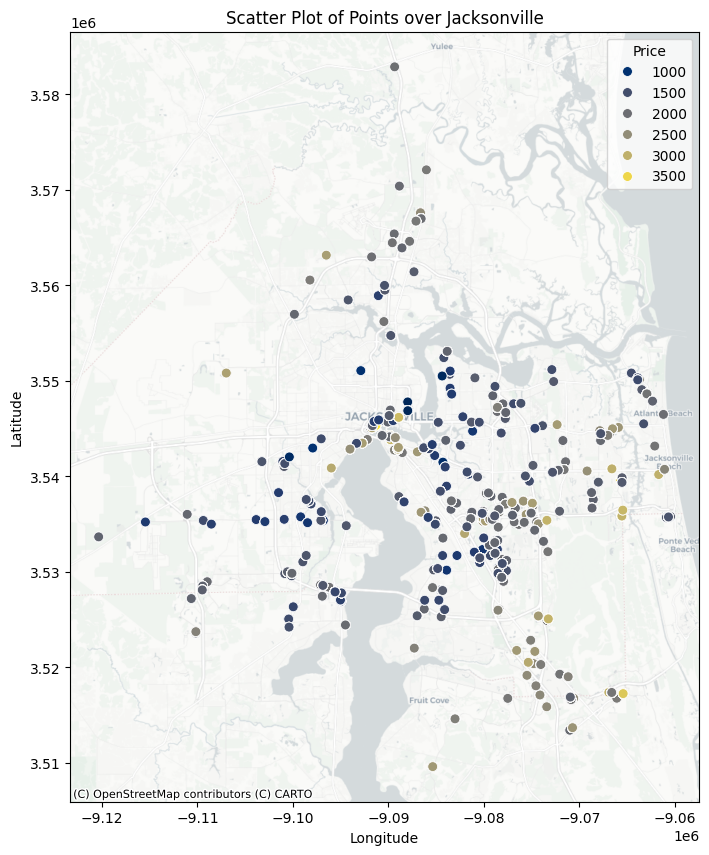

In [47]:
# Import necessary libraries for geospatial data handling and visualization
from shapely.geometry import box  # Creates a bounding box for a defined area
from matplotlib import pyplot as plt  # For plotting
import geopandas as gpd  # Handles spatial data in a Pandas-like format
import contextily as ctx  # Adds basemap tiles for better visualization
import seaborn as sns

# Define a bounding box around Jacksonville, FL using Shapely
# The coordinates represent (min_longitude, min_latitude, max_longitude, max_latitude)
jax_bbox = gpd.GeoDataFrame({
    'geometry': [box(-81.8, 30.1, -81.3, 30.6)]
}, crs="EPSG:4326")  # Set coordinate reference system to WGS84 (EPSG:4326)


# Ensure the CRS is EPSG:4326 (WGS 84) before reprojecting
finalDF = gpd.GeoDataFrame(finalDF, geometry=gpd.points_from_xy(finalDF['Longitude'], finalDF['Latitude']), crs="EPSG:4326")

# Reproject finalDF to EPSG:3857 (Web Mercator)
finalDF = finalDF.to_crs(epsg=3857)

# Also, make sure the bounding box is correctly reprojected
jax_bbox = jax_bbox.to_crs(epsg=3857)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

jitter_strength = 10  # Adjust this value based on how much jitter you want
finalDF['x_jittered'] = finalDF.geometry.x + np.random.uniform(-jitter_strength, jitter_strength, size=len(finalDF))
finalDF['y_jittered'] = finalDF.geometry.y + np.random.uniform(-jitter_strength, jitter_strength, size=len(finalDF))

# Plot the points from finalDF
sns.scatterplot(x=finalDF['x_jittered'], y=finalDF['y_jittered'], ax=ax, hue=finalDF['Price'], palette='cividis', s=50)# Add basemap tiles for context using Contextily
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)

# Customize plot labels and title
ax.set_title("Scatter Plot of Points over Jacksonville")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the plot
plt.show()

Lets try to identify some neighborhoods

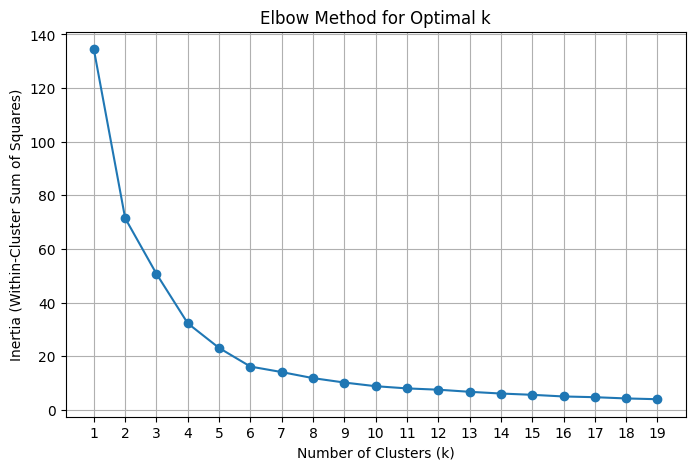

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

K_range = range(1,20)

inertia_values = []

for k in K_range:
    model = KMeans(n_clusters=k, random_state = 42, n_init = 10)
    model.fit(finalDF[['Longitude', 'Latitude']])
    inertia_values.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia_values, marker='o', linestyle = '-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

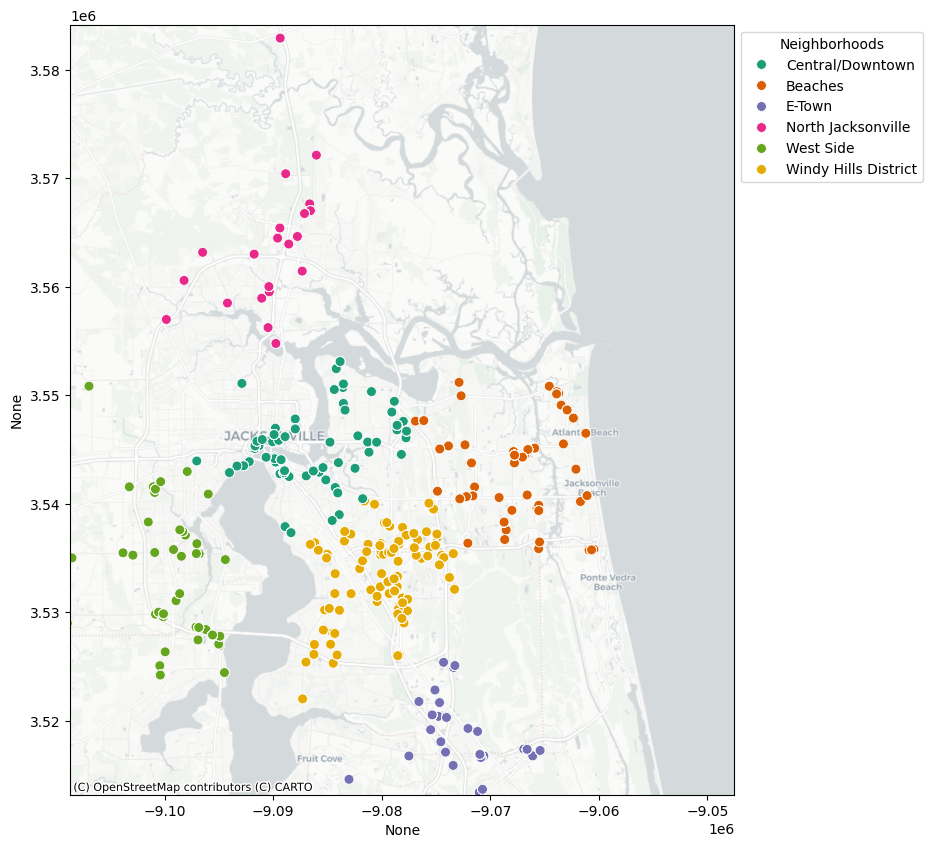

In [51]:
import seaborn as sns

model = KMeans(n_clusters= 6, random_state = 42, n_init = 10)
finalDF['Neighborhood'] = model.fit_predict(finalDF[['Longitude', 'Latitude']])
neighborhoodDictionary = {0: 'Central/Downtown',
                          1: 'Beaches',
                          2: 'E-Town',
                          3: 'North Jacksonville',
                          4: 'West Side', 
                          5: 'Windy Hills District'
                          }
unique_classes = sorted(finalDF['Neighborhood'].unique())
palette = dict(zip(unique_classes, sns.color_palette('Dark2', len(unique_classes))))
fig, ax = plt.subplots(figsize = (10,10))
jax_bbox.to_crs(epsg=3857).plot(ax = ax, alpha = 0, edgecolor = None)
ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron)
sns.scatterplot(x=finalDF.geometry.x, y=finalDF.geometry.y, ax=ax, hue=finalDF['Neighborhood'], palette= palette, s=50)

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Map the labels to the correct neighborhood names
# Here we use the `neighborhoodDictionary` to ensure proper labeling
updated_labels = [neighborhoodDictionary[int(label)] for label in labels]

# Update the legend
ax.legend(handles, updated_labels, title="Neighborhoods", loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# *This is what is affordable given a Biological Scientist I Salary*

Central Jacksonville is dangerous, and work is far south of Jacksonville. that leaves me one place to choose from in Orange Park. is that not something else?

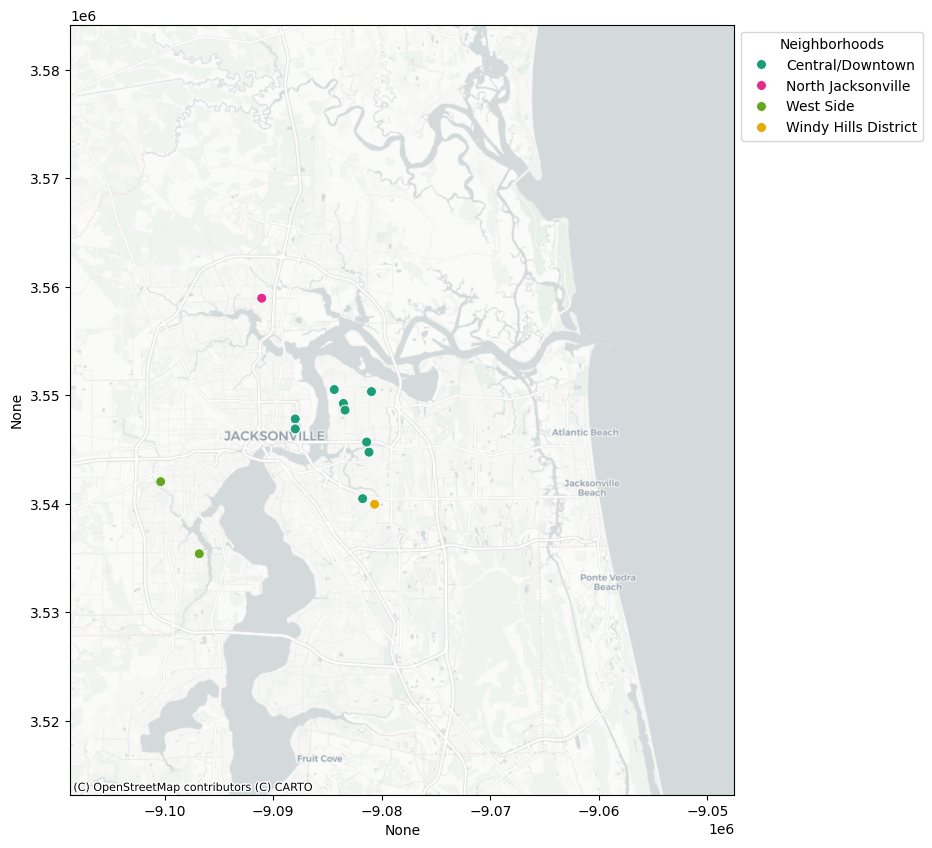

In [55]:
#affordables = finalDF.loc[(finalDF['Beds'] < 2) & (finalDF['Price'] < 900)]
affordables = finalDF.loc[finalDF['Price'] < 900]
fig, ax = plt.subplots(figsize = (10,10))
jax_bbox.to_crs(epsg=3857).plot(ax = ax, alpha = 0, edgecolor = None)
ctx.add_basemap(ax, source = ctx.providers.CartoDB.Positron)
sns.scatterplot(x=affordables.geometry.x, y=affordables.geometry.y, ax=ax, hue=affordables['Neighborhood'], palette= palette, s=50)

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Map the labels to the correct neighborhood names
# Here we use the `neighborhoodDictionary` to ensure proper labeling
updated_labels = [neighborhoodDictionary[int(label)] for label in labels]

# Update the legend
ax.legend(handles, updated_labels, title="Neighborhoods", loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [60]:
affordables.drop_duplicates(subset=['URL'])

Unnamed: 0         Floor Plan Name  Price      Unit Name  \
73            73  Mangrove(1 Bed 1 Bath)  850.0       Unit 810   
171          171             Lake studio  757.0       Unit 216   
2526        2526              Efficiency  860.0       Unit 107   
4639        4639             1/1 CLASSIC  899.0  Unit 12909-02   
5451        5451                   Daisy  894.0     Unit 01005   
5970        5970         1 Bedroom - 740  899.0    Unit AUCMAQ   
6638        6638               Town Home  880.0         Unit 3   
6652        6652               1 Bedroom  855.0       Unit 338   
6667        6667                   1 Bed  800.0         Unit 3   
6671        6671   0 Bedroom, 1 Bathroom  800.0     Unit F-071   
6901        6901                 3BD/1BA  786.0      Unit 10-3   
6927        6927                 One Bed  895.0         Unit 1   
6931        6931                 3BD/1BA  786.0      Unit 10-3   

      Square Footage Availability  Beds  Baths                           Name  \
73             884.0          Now   1.0    1.0      Red Bay Apartment Complex   
171            450.0          Now   0.5    1.0  Golden Shores of Jacksonville   
2526           288.0         Soon   0.5    1.0       Vintage Grove Apartments   
4639           800.0       Feb 28   1.0    1.0               River City Place   
5451           333.0          Now   0.5    1.0            Townsend Apartments   
5970           740.0          Now   1.0    1.0               Caroline Village   
6638          1863.0          Now   4.0    4.0                Jackson Commons   
6652           572.0          Now   1.0    1.0       Madison Manor Apartments   
6667           650.0         Soon   1.0    1.0        Trollie Lane Apartments   
6671           448.0        Mar 6   0.5    1.0                 Creekwood Club   
6901           750.0          Now   3.0    1.0               Eastside Terrace   
6927           600.0          Now   1.0    1.0            Paloma's Apartments   
6931           750.0          Now   3.0    1.0                Eastside Garden   

                                                    URL  \
73    https://www.apartments.com/red-bay-apartment-c...   
171   https://www.apartments.com/golden-shores-of-ja...   
2526  https://www.apartments.com/vintage-grove-apart...   
4639  https://www.apartments.com/river-city-place-ja...   
5451  https://www.apartments.com/townsend-apartments...   
5970  https://www.apartments.com/caroline-village-ja...   
6638  https://www.apartments.com/jackson-commons-jac...   
6652  https://www.apartments.com/madison-manor-apart...   
6667  https://www.apartments.com/trollie-lane-apartm...   
6671  https://www.apartments.com/creekwood-club-jack...   
6901  https://www.apartments.com/eastside-terrace-ja...   
6927  https://www.apartments.com/palomas-apartments-...   
6931  https://www.apartments.com/eastside-garden-jac...   

                                           Address  Longitude   Latitude  \
73     7528 Arlington Expy, Jacksonville, FL 32211 -81.579486  30.327247   
171          7703 Hare Ave, Jacksonville, FL 32211 -81.577540  30.319997   
2526     5262 Timuquana Rd, Jacksonville, FL 32210 -81.718022  30.247373   
4639         1275 Dunn Ave, Jacksonville, FL 32218 -81.666349  30.429942   
5451    3501 Townsend Blvd, Jacksonville, FL 32277 -81.575500  30.363270   
5970       2929 Justina Rd, Jacksonville, FL 32277 -81.598746  30.354828   
6638  3631 University Blvd, Jacksonville, FL 32277 -81.606277  30.364745   
6652         7400 Hogan Rd, Jacksonville, FL 32216 -81.582792  30.286775   
6667  2600-2641 Trollie Ln, Jacksonville, FL 32211 -81.597367  30.350062   
6671         8343 Hogan Rd, Jacksonville, FL 32216 -81.572920  30.282767   
6901        1230 E 7th St, Jacksonville, FL, 32206 -81.638601  30.343725   
6927       5930 Lenox Ave, Jacksonville, FL, 32205 -81.749948  30.298951   
6931        1212 E 1st St, Jacksonville, FL, 32206 -81.638556  30.336585   

                              geometry    x_jittered  

There is definitely a clear distinction. Lets see if we can extract some statistical data about the differences between groups.

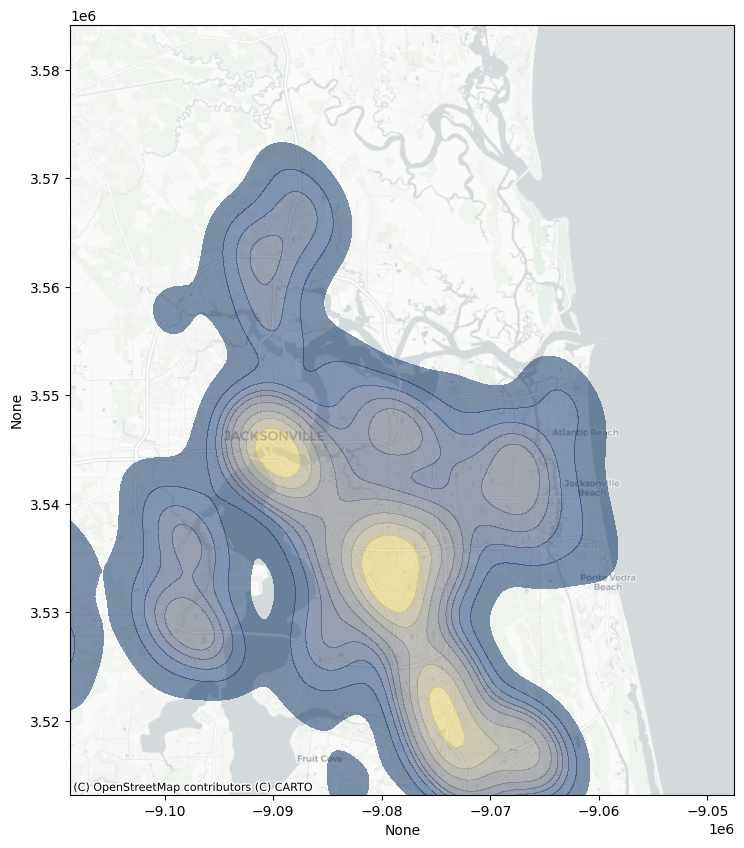

In [128]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
jax_bbox.to_crs(epsg=3857).plot(ax=ax, alpha=0, edgecolor=None)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot the KDE plot using the Longitude and Latitude columns
sns.kdeplot(x = finalDF.geometry.x, y = finalDF.geometry.y, ax=ax,  cmap = 'cividis', fill=True, alpha = 0.5)
# Show the plot
plt.show()

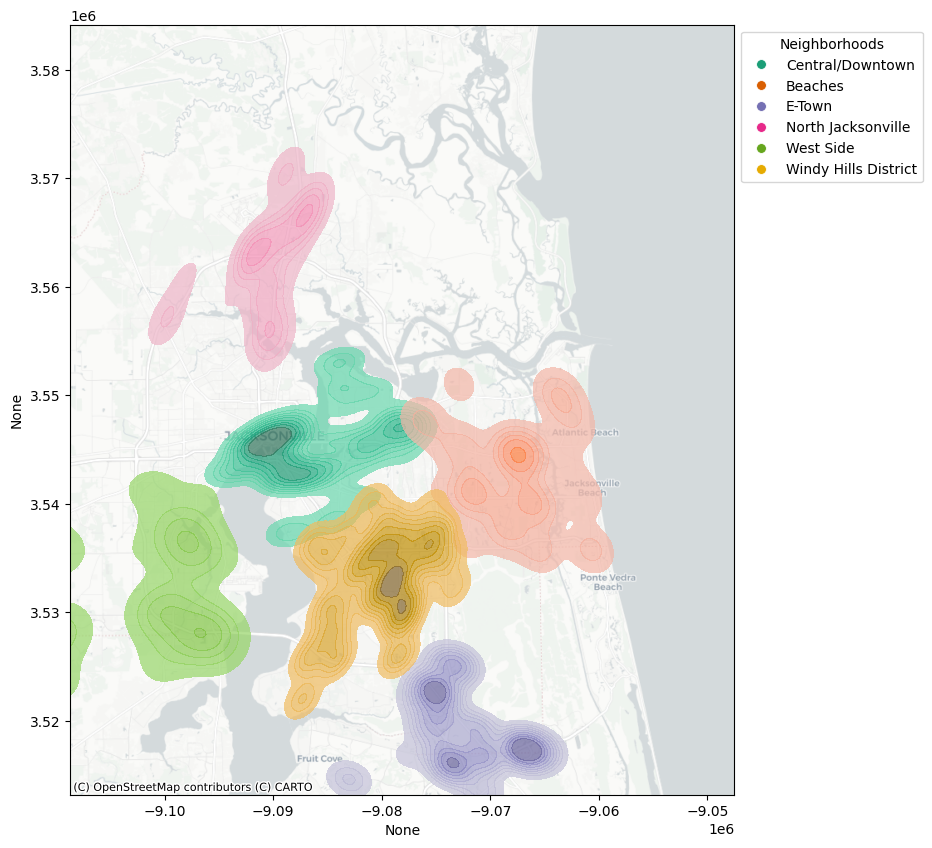

In [44]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
jax_bbox.to_crs(epsg=3857).plot(ax=ax, alpha=0, edgecolor=None)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot the KDE plot using the Longitude and Latitude columns
sns.kdeplot(x = finalDF.geometry.x, y = finalDF.geometry.y, ax=ax,  hue = finalDF.Neighborhood, palette = palette, fill=True, alpha = 0.7)
ax.legend(handles, updated_labels, title="Neighborhoods", loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

# Statistics

In [130]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
finalDF['DollarperSqFoot'] = finalDF['Price'] / finalDF['Square Footage']

model = ols('DollarperSqFoot ~ C(Neighborhood)', data = finalDF).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Increase float precision display
pd.options.display.float_format = '{:12f}'.format  # Adjust decimal places as needed

anova_table

sum_sq           df            F       PR(>F)
C(Neighborhood)   134.040812     5.000000   203.541988     0.000000
Residual          914.713912  6945.000000          NaN          NaN

In [131]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

finalDF['Neighborhood'] = finalDF['Neighborhood'].apply(lambda x: neighborhoodDictionary[x])
tukey_results = pairwise_tukeyhsd(finalDF['DollarperSqFoot'], finalDF['Neighborhood'], alpha=0.05)
postHocPricePerFoot = pd.DataFrame(tukey_results.summary().data[1:], columns=tukey_results.summary().data[0])
print(finalDF.groupby('Neighborhood')['DollarperSqFoot'].mean())
postHocPricePerFoot

Neighborhood
Beaches                    1.759159
Central/Downtown           1.809167
E-Town                     1.868705
North Jacksonville         1.520030
West Side                  1.458401
Windy Hills District       1.656806
Name: DollarperSqFoot, dtype: float64


group1                group2     meandiff        p-adj  \
0              Beaches      Central/Downtown     0.050000     0.021400   
1              Beaches                E-Town     0.109500     0.000000   
2              Beaches    North Jacksonville    -0.239100     0.000000   
3              Beaches             West Side    -0.300800     0.000000   
4              Beaches  Windy Hills District    -0.102400     0.000000   
5     Central/Downtown                E-Town     0.059500     0.000100   
6     Central/Downtown    North Jacksonville    -0.289100     0.000000   
7     Central/Downtown             West Side    -0.350800     0.000000   
8     Central/Downtown  Windy Hills District    -0.152400     0.000000   
9               E-Town    North Jacksonville    -0.348700     0.000000   
10              E-Town             West Side    -0.410300     0.000000   
11              E-Town  Windy Hills District    -0.211900     0.000000   
12  North Jacksonville             West Side    -0.061600     0.024500   
13  North Jacksonville  Windy Hills District     0.136800     0.000000   
14           West Side  Windy Hills District     0.198400     0.000000   

          lower        upper  reject  
0      0.004500     0.095500    True  
1      0.065000     0.154100    True  
2     -0.296500    -0.181800    True  
3     -0.351200    -0.250300    True  
4     -0.146000    -0.058700    True  
5      0.021400     0.097700    True  
6     -0.341700    -0.236600    True  
7     -0.395600    -0.305900    True  
8     -0.189400    -0.115300    True  
9     -0.400400    -0.297000    True  
10    -0.454200    -0.366400    True  
11    -0.247800    -0.176000    True  
12    -0.118500    -0.004800    True  
13     0.085900     0.187700    True  
14     0.155400     0.241400    True

C:\Users\Waxli\AppData\Local\Temp\ipykernel_18848\3582651532.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  categories=finalDF.groupby("Neighborhood")["DollarperSqFoot"].median().sort_values(ascending=True).index,


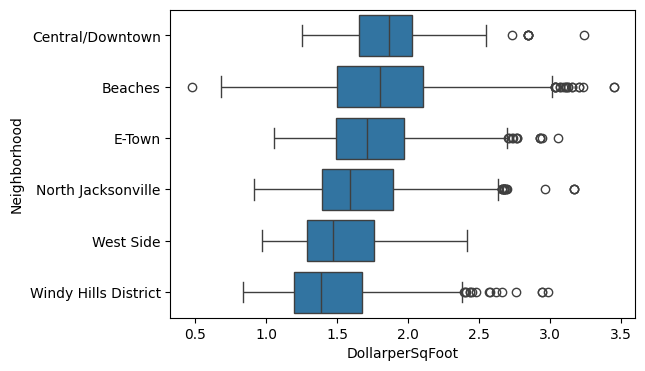

In [54]:
# Ensure 'Neighborhood' is ordered based on DollarperSqFoot median
finalDF["Neighborhood"] = pd.Categorical(
    finalDF["Neighborhood"],
    categories=finalDF.groupby("Neighborhood")["DollarperSqFoot"].median().sort_values(ascending=True).index,
    ordered=True
)

plt.figure(figsize = (6,4))
ax = sns.boxplot(data = finalDF, x = 'DollarperSqFoot', y = 'Neighborhood', orient= 'h')
ax.set_yticks(list(neighborhoodDictionary.keys()))
ax.set_yticklabels(list(neighborhoodDictionary.values()))
plt.show()

Remove outliers via IQR

In [43]:
def remove_outliers(neighborhood):
    Q1 = neighborhood["DollarperSqFoot"].quantile(0.25)
    Q3 = neighborhood["DollarperSqFoot"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return neighborhood[(neighborhood["DollarperSqFoot"] >= lower_bound) & (neighborhood["DollarperSqFoot"] <= upper_bound)]

# Apply the function by neighborhood
IQR_filtered_units = finalDF.groupby("Neighborhood", group_keys=False).apply(remove_outliers)

print(f"Original count: {len(finalDF)}, Filtered count: {len(IQR_filtered_units)}")

Original count: 6951, Filtered count: 6880


C:\Users\Waxli\AppData\Local\Temp\ipykernel_9084\3297105180.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  IQR_filtered_units = finalDF.groupby("Neighborhood", group_keys=False).apply(remove_outliers)


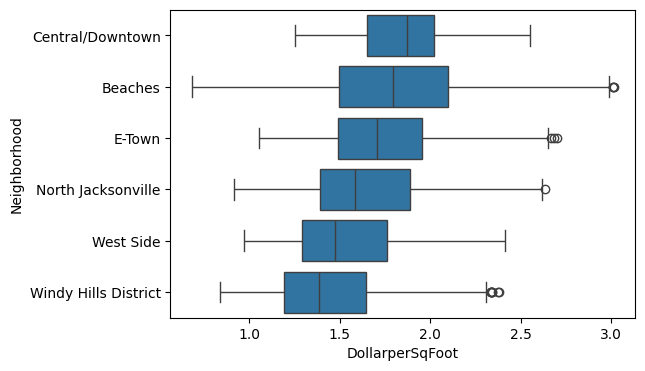

In [56]:
plt.figure(figsize = (6,4))
ax = sns.boxplot(data = IQR_filtered_units, x = 'DollarperSqFoot', y = 'Neighborhood', orient= 'h')
ax.set_yticks(list(neighborhoodDictionary.keys()))
ax.set_yticklabels(list(neighborhoodDictionary.values()))
plt.show()

<Figure size 3000x3000 with 0 Axes>

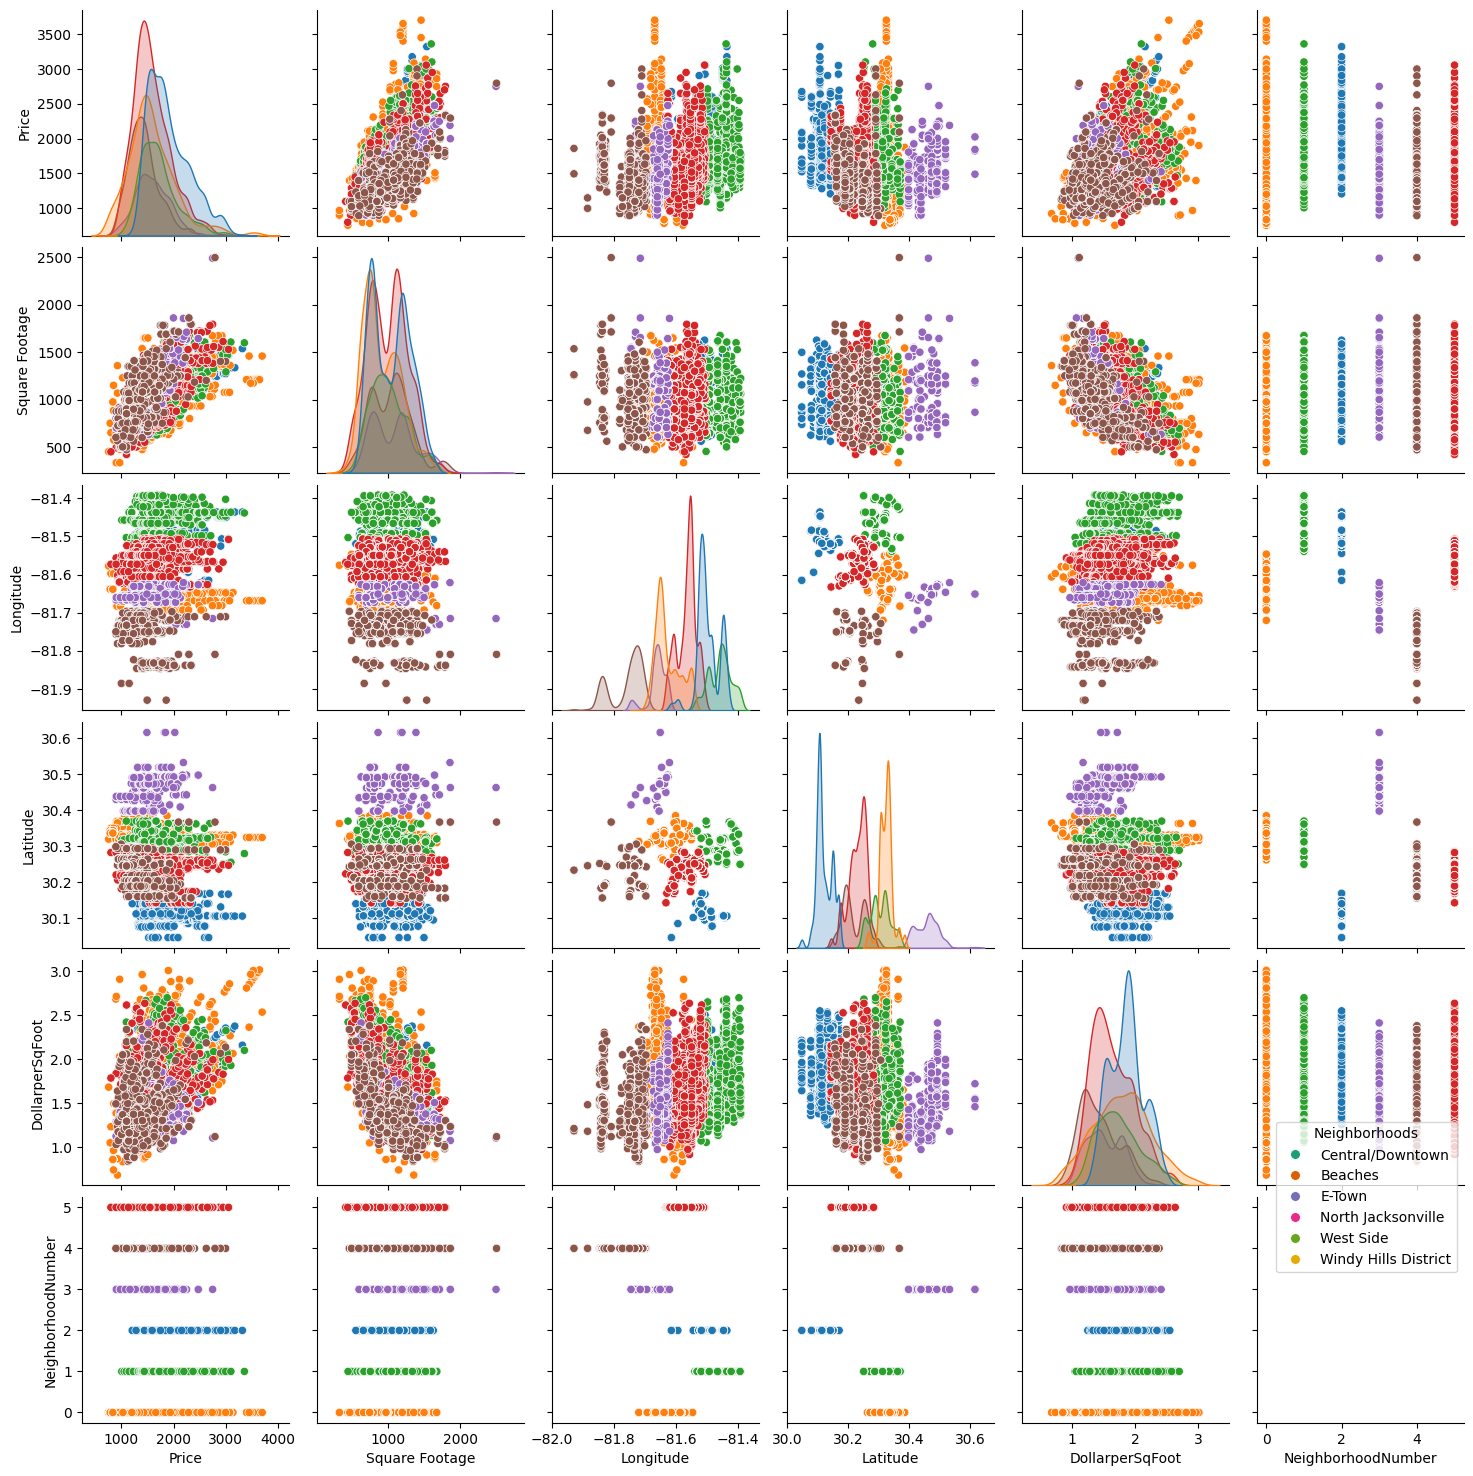

In [63]:
plt.figure(figsize = (30,30))
ax = sns.pairplot(data = IQR_filtered_units.drop(['x_jittered', 'y_jittered', 'Beds', 'Baths'], axis = 1), hue = "Neighborhood",plot_kws={'legend': False})
ax._legend.remove()
plt.legend(handles, updated_labels, title="Neighborhoods", loc='right', bbox_to_anchor=(1, 1))

plt.show()

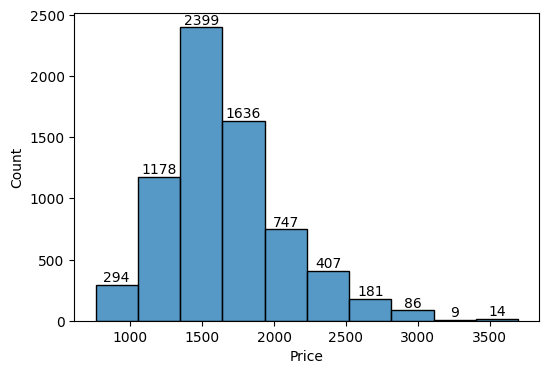

In [45]:
plt.figure(figsize = (6,4))

ax = sns.histplot(data = finalDF, x = "Price", bins=10, stat='count')
for p in ax.patches:
    height = p.get_height()  # Get bar height (count)
    if height > 0:  # Only label bars with nonzero count
        ax.text(p.get_x() + p.get_width() / 2,  # X-coordinate (center of bar)
                height + 1,  # Y-coordinate (slightly above the bar)
                f'{int(height)}',  # Text (count value)
                ha='center', va='bottom', fontsize=10, color='black')
        
plt.show()

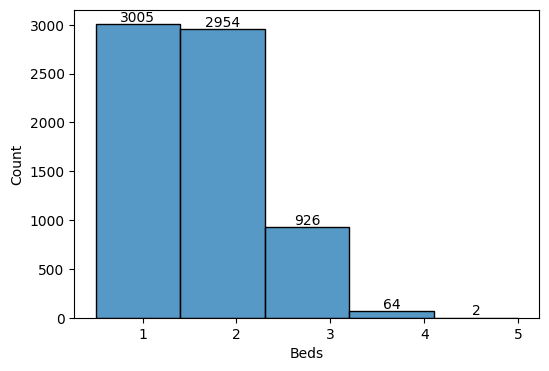

In [40]:
plt.figure(figsize = (6,4))
ax = sns.histplot(data = finalDF, x = "Beds", bins=5, stat='count')
for p in ax.patches:
    height = p.get_height()  # Get bar height (count)
    if height > 0:  # Only label bars with nonzero count
        ax.text(p.get_x() + p.get_width() / 2,  # X-coordinate (center of bar)
                height + 1,  # Y-coordinate (slightly above the bar)
                f'{int(height)}',  # Text (count value)
                ha='center', va='bottom', fontsize=10, color='black')
plt.show()

In [19]:
finalDF.loc[finalDF['Price'] < 1000, 'URL'].unique()

array(['https://www.apartments.com/red-bay-apartment-complex-jacksonville-fl/ksmqmkc/',
       'https://www.apartments.com/golden-shores-of-jacksonville-jacksonville-fl/t3pktn8/',
       'https://www.apartments.com/pier-5350-jacksonville-fl/tpgyv3b/',
       'https://www.apartments.com/bentley-green-apartment-homes-jacksonville-fl/sh49236/',
       'https://www.apartments.com/one-at-mandarin-jacksonville-fl/1hjwy97/',
       'https://www.apartments.com/vintage-grove-apartments-jacksonville-fl/6snzwzr/',
       'https://www.apartments.com/the-square-at-59-caroline-jacksonville-fl/rrglsf0/',
       'https://www.apartments.com/park-place-apartments-jacksonville-fl/54glelm/',
       'https://www.apartments.com/heron-walk-jacksonville-fl/t8twtqc/',
       'https://www.apartments.com/lenox-cove-newly-designed-apartments-jacksonville-fl/8ktt8d0/',
       'https://www.apartments.com/river-city-place-jacksonville-fl/l8p73re/',
       'https://www.apartments.com/townsend-apartments-jacksonville-

<Axes: >

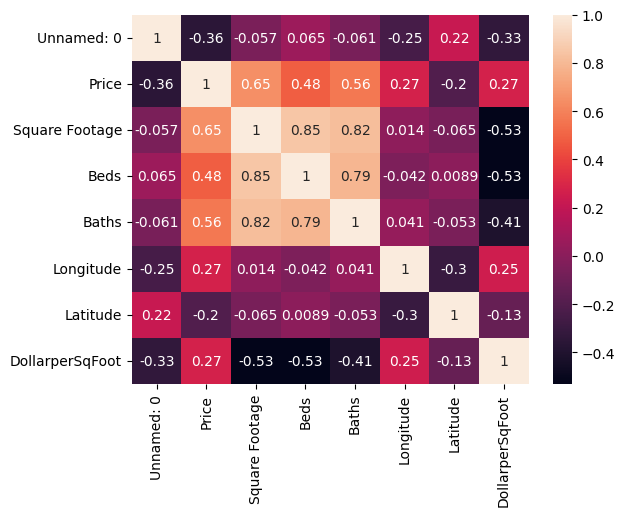

In [44]:
sns.heatmap(IQR_filtered_units.drop([ 'y_jittered', 'x_jittered', 'Neighborhood', 'NeighborhoodNumber'], axis = 1).corr(numeric_only= True), annot=True)

In [65]:
IQR_filtered_units.corr(numeric_only=True)

Price  Square Footage      Beds     Baths  Longitude  \
Price               1.000000        0.645412  0.484179  0.563638   0.270053   
Square Footage      0.645412        1.000000  0.848230  0.817976   0.014155   
Beds                0.484179        0.848230  1.000000  0.789322  -0.042070   
Baths               0.563638        0.817976  0.789322  1.000000   0.040791   
Longitude           0.270053        0.014155 -0.042070  0.040791   1.000000   
Latitude           -0.203012       -0.064667  0.008894 -0.053163  -0.302143   
x_jittered          0.270051        0.014152 -0.042072  0.040790   1.000000   
y_jittered         -0.202884       -0.064576  0.008928 -0.053116  -0.302079   
DollarperSqFoot     0.270685       -0.531867 -0.531324 -0.412014   0.246689   
NeighborhoodNumber -0.121770        0.084399  0.061755  0.071892  -0.185181   

                    Latitude  x_jittered  y_jittered  DollarperSqFoot  \
Price              -0.203012    0.270051   -0.202884         0.270685   
Square Footage     -0.064667    0.014152   -0.064576        -0.531867   
Beds                0.008894   -0.042072    0.008928        -0.531324   
Baths              -0.053163    0.040790   -0.053116        -0.412014   
Longitude          -0.302143    1.000000   -0.302079         0.246689   
Latitude            1.000000   -0.302143    1.000000        -0.126596   
x_jittered         -0.302143    1.000000   -0.302080         0.246688   
y_jittered          1.000000   -0.302080    1.000000        -0.126574   
DollarperSqFoot    -0.126596    0.246688   -0.126574         1.000000   
NeighborhoodNumber -0.226696   -0.185182   -0.226747        -0.233312   

                    NeighborhoodNumber  
Price                        -0.121770  
Square Footage                0.084399  
Beds                          0.061755  
Baths                         0.071892  
Longitude                    -0.185181  
Latitude                     -0.226696  
x_jittered                   -0.185182  
y_jittered                   -0.226747  
DollarperSqFoot              -0.233312  
NeighborhoodNumber            1.000000

Lets pull in some crime data

In [ ]:
# Load the GeoJSON file into a GeoDataFrame
crimes = gpd.read_file("JSO_NIBRS_Incidents_3940639262161538110.geojson")
crimesDF = pd.DataFrame(crimes)
crimesDF["Longitude"] = crimes.geometry.x
crimesDF["Latitude"] = crimes.geometry.y
# Convert the GeoDataFrame to a pandas DataFrame
crimes = crimes.to_crs(epsg=3857)

In [69]:
print(crimes.shape)
crimes.head()

(10416, 8)


ObjectID           CCR                Address  \
0    301797  202500051657      9400 ARBOR OAK LN   
1    302968  202500064629          8700 KONA AVE   
2    302965  202500064964         5500 JAMMES RD   
3    299905  202500028829  6600 BENNETT CREEK DR   
4    302390  202500058579       7100 WILSON BLVD   

                  ReportDateTime               IncidentDateTime  \
0  Mon, 27 Jan 2025 00:07:00 GMT  Sun, 26 Jan 2025 04:00:00 GMT   
1  Sun, 02 Feb 2025 03:39:00 GMT  Sun, 02 Feb 2025 00:30:00 GMT   
2  Sun, 02 Feb 2025 08:58:00 GMT  Sun, 02 Feb 2025 08:10:00 GMT   
3  Wed, 15 Jan 2025 10:30:00 GMT  Wed, 15 Jan 2025 09:00:00 GMT   
4  Thu, 30 Jan 2025 04:55:00 GMT  Thu, 30 Jan 2025 03:30:00 GMT   

            NibrsDescription  VictimCount                          geometry  
0         WEAPONS VIOLATIONS            1  POINT (-9094830.615 3556215.286)  
1  CURFEW/LOITERING/VAGRANCY            1   POINT (-9079918.493 3545124.54)  
2                   BURGLARY            1  POINT (-9100104.545 3535363.679)  
3             SIMPLE ASSAULT            1  POINT (-9083330.451 3537337.126)  
4         AGGRAVATED ASSAULT            1  POINT (-9101729.238 3538292.701)

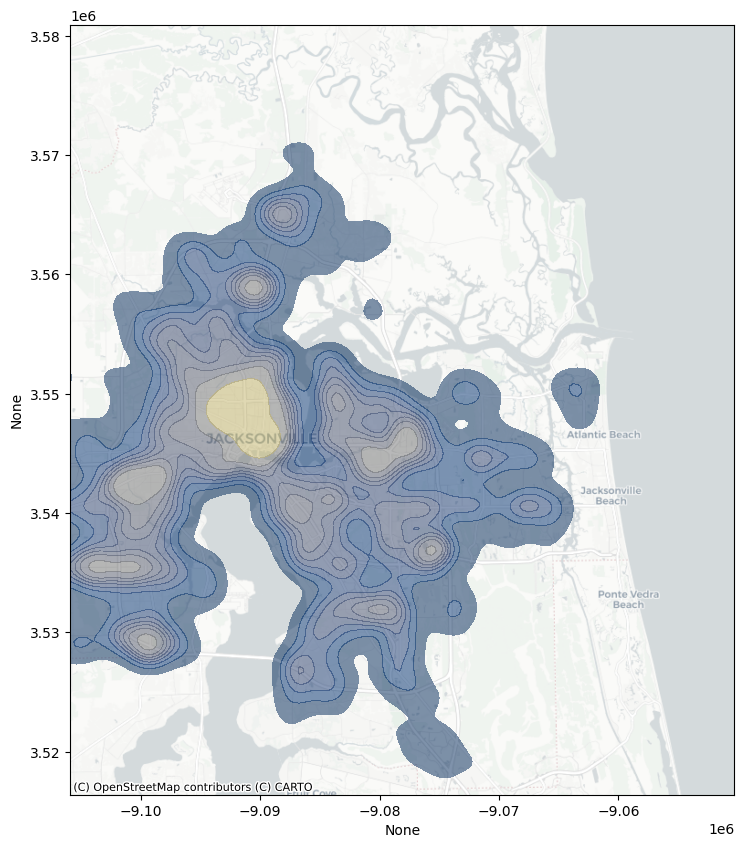

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
jax_bbox.to_crs(epsg=3857).plot(ax=ax, alpha=0, edgecolor=None)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot the KDE plot using the Longitude and Latitude columns
sns.kdeplot(x = crimes.geometry.x, y = crimes.geometry.y, ax=ax,  cmap = 'cividis', fill=True, alpha = 0.5, bw_adjust= 0.5)

# Show the plot
plt.show()

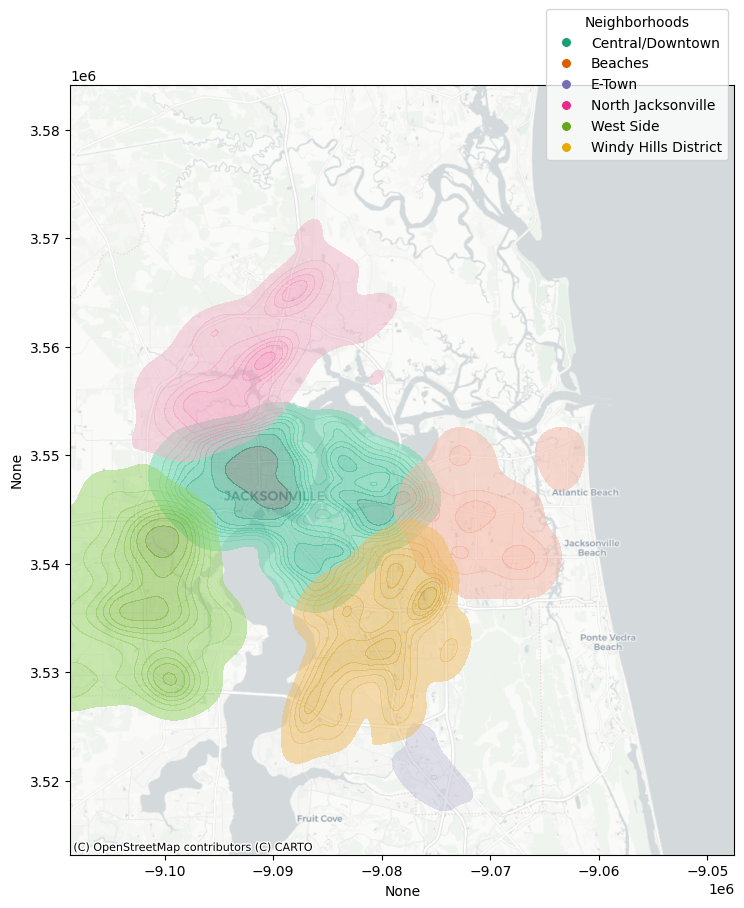

In [71]:
crimes['Neighborhood'] = model.predict(crimesDF[['Longitude', 'Latitude']])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the base map
jax_bbox.to_crs(epsg=3857).plot(ax=ax, alpha=0, edgecolor=None)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Plot the KDE plot using the Longitude and Latitude columns
sns.kdeplot(x = crimes.geometry.x, y = crimes.geometry.y, ax=ax,  hue = crimes.Neighborhood, palette = palette, fill=True, alpha = 0.5)
# Show the plot

ax.legend(handles, updated_labels, title="Neighborhoods", loc='right', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
finalDF.to_csv('actualrealFinal_3-1-2025.csv', index= False)
crimes.to_csv('crimes_3-1-2025.csv', index=False)

# Prediction

In [80]:
X = IQR_filtered_units[['Longitude', 'Latitude', 'Square Footage']]
y = IQR_filtered_units['Price']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



regr = linear_model.LinearRegression()
regr.fit(X_train_scaled, y_train)
y_pred = regr.predict(X_test_scaled)



mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")  # Higher R² means better fit

# Perform 5-fold cross-validation on the entire dataset (not just X_test)
cv_scores = cross_val_score(regr, X, y, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")

MAE: 222.71318563508765
MSE: 84068.48265678328
RMSE: 289.9456546609783
R²: 0.513929553246181
Cross-validated R² scores: [0.34675525 0.12350409 0.4567799  0.3465133  0.07859138]
Mean R²: 0.2704
Standard Deviation of R²: 0.1447


# Random Forest

In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Train Random Forest Regressor
regressor = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=5, 
    max_features='sqrt', 
    random_state=23, 
    oob_score=True
)
regressor.fit(X_train_scaled, y_train)

# Predictions
y_pred = regressor.predict(X_test_scaled)

# Error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")  # Higher R² means better fit
print(f"OOB R² Score: {regressor.oob_score_:.4f}")  # Out-of-bag score

# Perform 5-fold cross-validation on the entire dataset (not just X_test)
cv_scores = cross_val_score(regressor, X, y, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")

MAE: 85.6290
MSE: 14549.7907
RMSE: 120.6225
R²: 0.9159
OOB R² Score: 0.9054
Cross-validated R² scores: [-0.17024961  0.08712737  0.36896403  0.56076292 -0.80851387]
Mean R²: 0.0076
Standard Deviation of R²: 0.4776


# XGBoost

In [83]:
import xgboost as xgb

# Initialize the model
xg_reg = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    colsample_bytree = 0.3,
    learning_rate = 0.1,
    max_depth = 5,
    alpha = 10,
    n_estimators = 100
              )

# Fit model
xg_reg.fit(X_train_scaled, y_train)

# Predict
y_pred = xg_reg.predict(X_test_scaled)

#Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Perform 5-fold cross-validation on the entire dataset (not just X_test)
cv_scores = cross_val_score(xg_reg, X, y, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")

MAE: 114.3916
MSE: 24739.4406
RMSE: 157.2878
R²: 0.8570
Cross-validated R² scores: [-0.44083312  0.01984404  0.05501446  0.45217954  0.0125504 ]
Mean R²: 0.0198
Standard Deviation of R²: 0.2830


# LinReg with Ridge Regression

In [84]:
from sklearn.linear_model import Ridge

#initialize the model
ridge_reg = Ridge(alpha = 1.0)


#fit the model
ridge_reg.fit(X_train_scaled, y_train)

#Predict
y_pred = ridge_reg.predict(X_test_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Perform 5-fold cross-validation on the entire dataset (not just X_test)
cv_scores = cross_val_score(ridge_reg, X, y, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")

MAE: 222.7131
MSE: 84069.1548
RMSE: 289.9468
R²: 0.5139
Cross-validated R² scores: [0.34370161 0.12728517 0.459713   0.34713557 0.07307099]
Mean R²: 0.2702
Standard Deviation of R²: 0.1460


# K-Nearest Neighbors Regression

In [85]:
from sklearn.neighbors import KNeighborsRegressor

#initialize the model
knn_reg = KNeighborsRegressor(n_neighbors = 6)

#train the model
knn_reg.fit(X_train_scaled, y_train)

#Predict
y_pred = knn_reg.predict(X_test_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


# Perform 5-fold cross-validation on the entire dataset (not just X_test)
cv_scores = cross_val_score(knn_reg, X, y, cv=5, scoring='r2')

# Print cross-validation results
print(f"Cross-validated R² scores: {cv_scores}")
print(f"Mean R²: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of R²: {np.std(cv_scores):.4f}")

MAE: 92.6070
MSE: 22429.3357
RMSE: 149.7643
R²: 0.8703
Cross-validated R² scores: [ 0.18486207  0.20528818  0.09631001  0.06237532 -0.59661564]
Mean R²: -0.0096
Standard Deviation of R²: 0.2983


# PCA

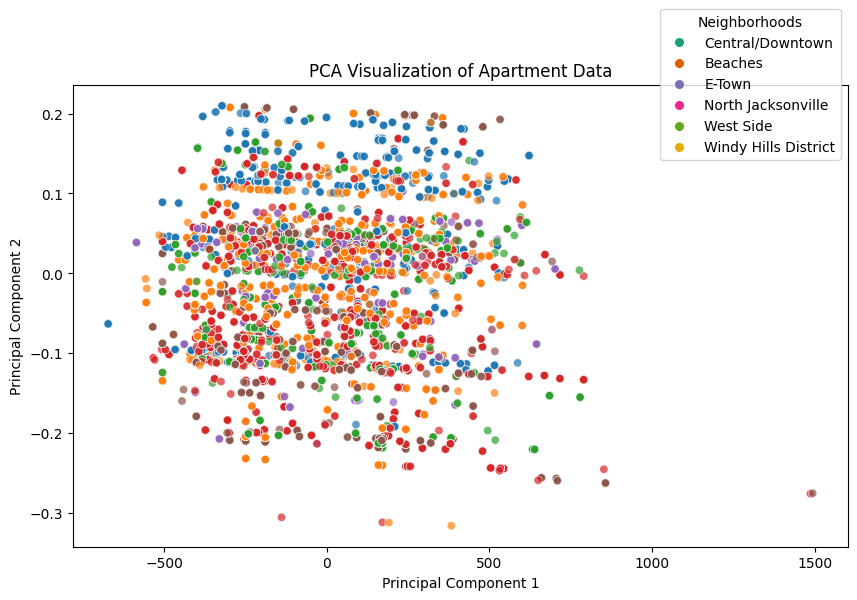

In [87]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(X)

pca_df = pd.DataFrame(data = principal_components, columns = ["PC1", "PC2"])
pca_df["Neighborhood"] = IQR_filtered_units["Neighborhood"]


plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue= "Neighborhood", palette="tab10", alpha=0.7)
plt.title("PCA Visualization of Apartment Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(handles, updated_labels, title="Neighborhoods", loc='right', bbox_to_anchor=(1, 1))
plt.show()